In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a0dc93e8faaf708c24adf617eafa99f052c88443f42abdd3edaeee2773ab2624
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [5]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Pyspark, SQL and Machine Learning for salary prediction", conf=conf)
sc

<SparkContext master=local[*] appName=Pyspark, SQL and Machine Learning for salary prediction>

In [6]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [10]:
df1 = spark.read.csv('train_dataset.csv', header=True).cache()

In [11]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [12]:
df2 = spark.read.csv('train_salaries.csv', header=True).cache()

In [13]:
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



In [14]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [15]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [16]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [17]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [18]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [19]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



In [20]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [21]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [22]:
df = df.drop('job_id')

In [23]:
df.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|   101|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|   137|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|   142|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|   163|
+----------------+---------+--------------+-----------+-

In [24]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



In [25]:
df.show(10)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|   HEALTH|             10|                 38|   137|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS|  FINANCE|              8|                 16|   163|
|JOB1362684407692|   COMP15|       MANAGER|   DO

In [26]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 17107
Number of missing values for major: 38218
Number of missing values for industry: 0


In [27]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+------------------+-------------------+------------------+
|summary|   yearsExperience|milesFromMetropolis|            salary|
+-------+------------------+-------------------+------------------+
|  count|             71556|              71556|             71556|
|   mean|11.929439879255408|  49.40467605791268|115.84820280619375|
| stddev|7.2052713468704335|  28.79324682550413|38.617989028931824|
|    min|                 0|                  0|                 0|
|    max|                24|                 99|               292|
+-------+------------------+-------------------+------------------+



In [28]:
df.createOrReplaceTempView("data")

In [29]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   292|    CEO| FINANCE|
+------+-------+--------+



In [30]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   292|    CEO| FINANCE|   1|
|   288|    CFO| FINANCE|   2|
|   286|    CEO|     OIL|   1|
|   285|    CEO|     OIL|   2|
|   283|    CFO| FINANCE|   3|
|   280|    CEO|     WEB|   1|
|   277|    CEO| FINANCE|   4|
|   275|    CEO|     OIL|   3|
|   275|    CEO|     OIL|   3|
|   273|    CEO|     OIL|   5|
|   272|    CEO| FINANCE|   5|
|   271|    CFO|     OIL|   6|
|   271|    CTO| FINANCE|   6|
|   271|    CFO| FINANCE|   6|
|   270|    CEO| FINANCE|   8|
|   270|    CFO|     OIL|   7|
|   270|    CTO|     WEB|   2|
|   269|    CEO| FINANCE|   9|
|   268|    CEO|     OIL|   8|
|   266|    CEO| FINANCE|  10|
+------+-------+--------+----+



In [31]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|     0| JUNIOR|     AUTO|   1|
|    19|JANITOR|EDUCATION|   1|
|    19|JANITOR|EDUCATION|   1|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    21|JANITOR|EDUCATION|   7|
|    21|JANITOR|EDUCATION|   7|
|    21|JANITOR|EDUCATION|   7|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|  SERVICE|   1|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
+------+-------+---------+----+
only showing top 20 rows



In [32]:
df = df.where("salary != 0")

In [33]:
df.createOrReplaceTempView("data")

In [34]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    19|JANITOR|EDUCATION|   1|
|    19|JANITOR|EDUCATION|   1|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    20|JANITOR|EDUCATION|   3|
|    21|JANITOR|EDUCATION|   7|
|    21|JANITOR|EDUCATION|   7|
|    21|JANITOR|EDUCATION|   7|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|EDUCATION|  10|
|    22|JANITOR|  SERVICE|   1|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
|    23|JANITOR|EDUCATION|  14|
+------+-------+---------+----+
only showing top 20 rows



In [35]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)


+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.74107671070794|
|  FINANCE| 130.4595151634115|
|      WEB|120.88052922590838|
|   HEALTH|  116.403933727352|
|     AUTO|109.38445727708721|
|  SERVICE| 103.9471186440678|
|EDUCATION| 99.47112283787746|
+---------+------------------+



<ipython-input-36-485dc33e00de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')


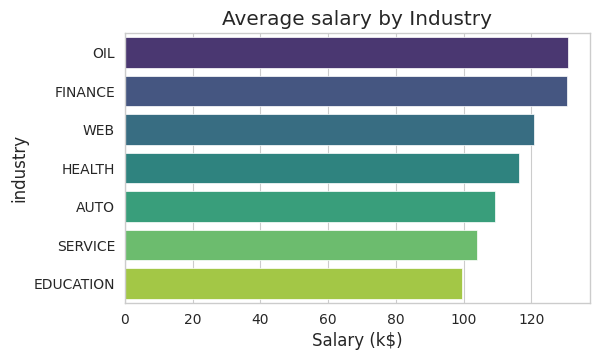

In [36]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

In [37]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''')
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   292|    CEO| FINANCE|             22|
|   288|    CFO| FINANCE|             21|
|   286|    CEO|     OIL|             16|
|   285|    CEO|     OIL|             20|
|   283|    CFO| FINANCE|             19|
|   280|    CEO|     WEB|             24|
|   277|    CEO| FINANCE|             22|
|   275|    CEO|     OIL|             23|
|   275|    CEO|     OIL|             19|
|   273|    CEO|     OIL|             14|
|   272|    CEO| FINANCE|             22|
|   271|    CTO| FINANCE|             22|
|   271|    CFO|     OIL|             21|
|   271|    CFO| FINANCE|             20|
|   270|    CEO| FINANCE|             19|
|   270|    CTO|     WEB|             24|
|   270|    CFO|     OIL|             24|
|   269|    CEO| FINANCE|             24|
|   268|    CEO|     OIL|             23|
|   266|    CEO| FINANCE|             23|
+------+-------+--------+---------

In [38]:
df_q5.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO| 8826|
|        JUNIOR| 8840|
|       JANITOR| 9003|
|           CFO| 8930|
|           CEO| 9034|
|       MANAGER| 8849|
|VICE_PRESIDENT| 9037|
|        SENIOR| 9036|
+--------------+-----+



In [39]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

In [40]:
df_p = df_q5.toPandas()

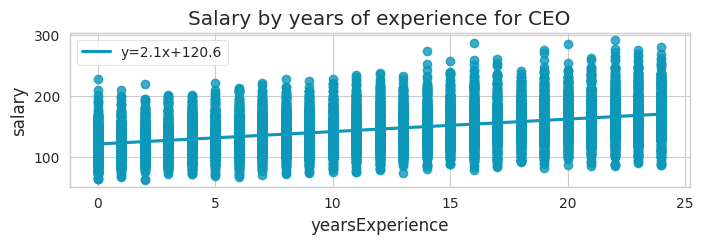

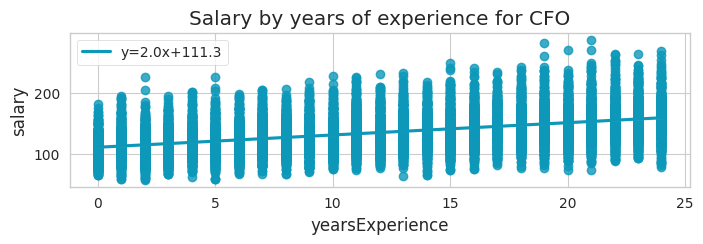

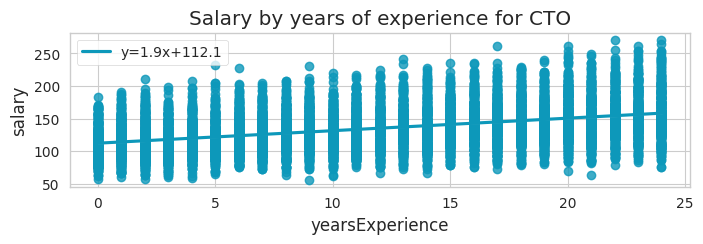

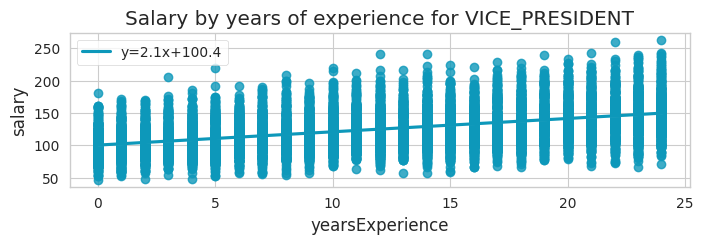

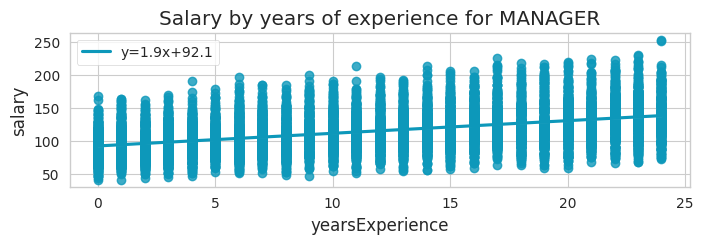

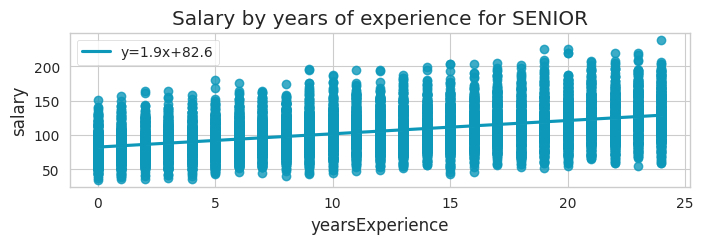

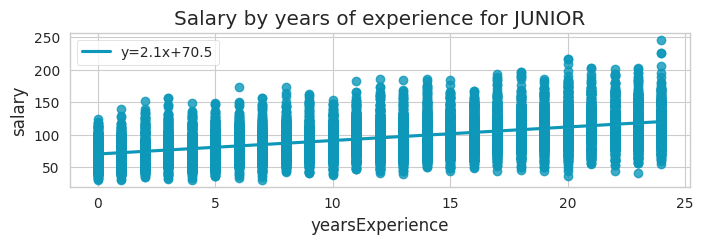

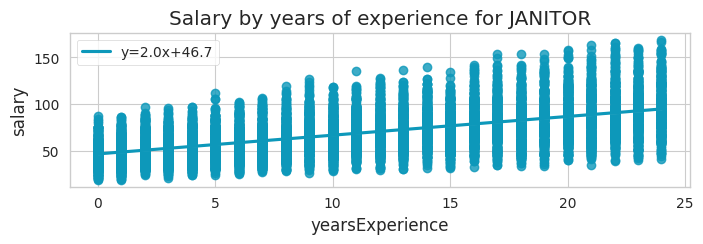

In [41]:
slope_list = []
intercept_list = []

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

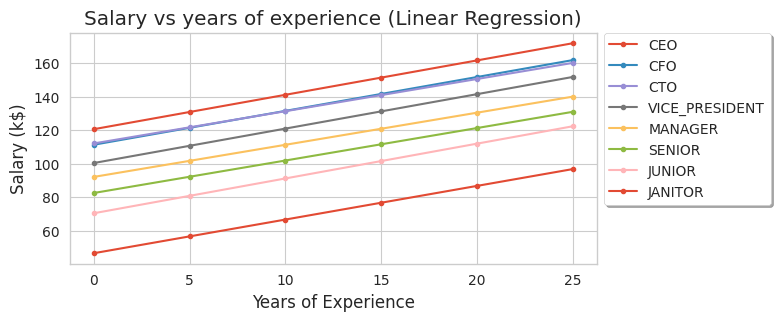

In [42]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

In [43]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    19|JANITOR|
|       NONE|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|       NONE|    20|JANITOR|
|       NONE|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [44]:
df_q6 = df_q6.replace('NONE',None)

In [45]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NULL|    19|JANITOR|
|       NULL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|       NULL|    20|JANITOR|
|       NULL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [46]:
df_q6 = df_q6.na.drop()

In [47]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    20|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
|HIGH_SCHOOL|    21|JANITOR|
|HIGH_SCHOOL|    22|JANITOR|
|HIGH_SCHOOL|    22|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [48]:
df_q6.groupBy('degree').count().show()

+-----------+-----+
|     degree|count|
+-----------+-----+
|  BACHELORS|12549|
|    MASTERS|12489|
|HIGH_SCHOOL|16897|
|   DOCTORAL|12513|
+-----------+-----+



In [49]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

In [50]:
df_p = df_q6.toPandas()

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


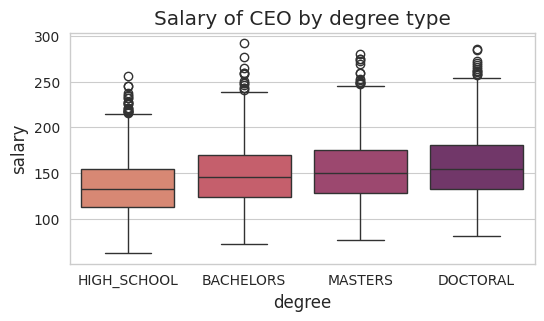

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


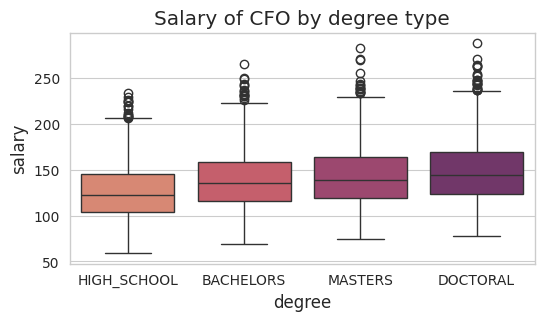

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


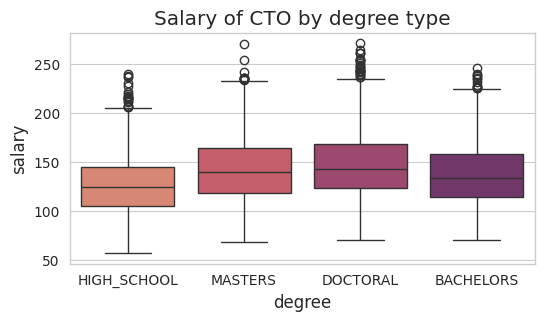

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


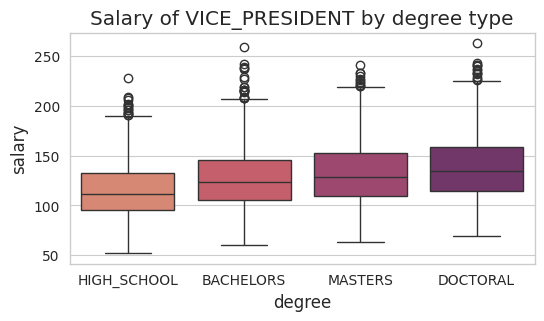

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


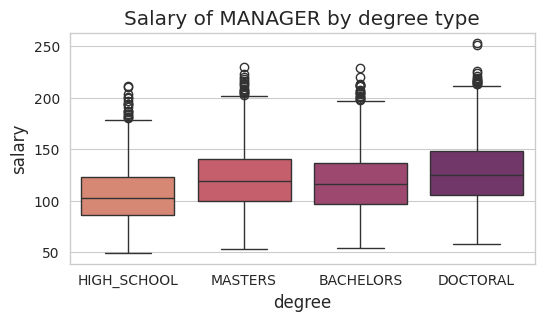

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


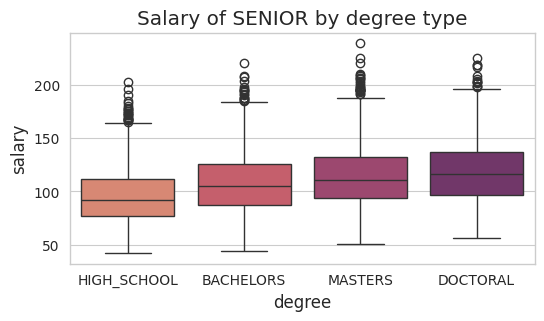

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


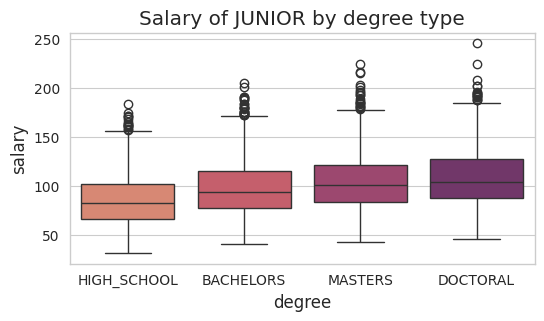

<ipython-input-51-c6d10aa40e88>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')


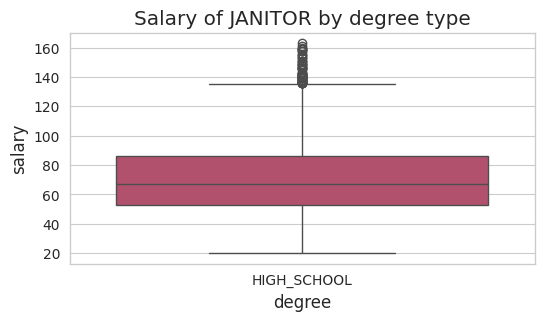

In [51]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

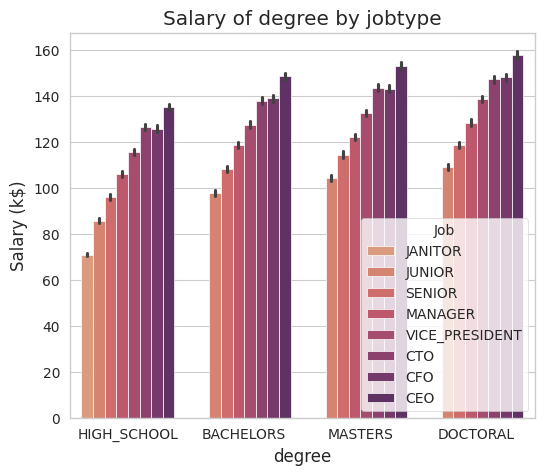

In [52]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

In [53]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    19|
|JANITOR|       NONE| NONE|    19|
|JANITOR|HIGH_SCHOOL| NONE|    20|
|JANITOR|       NONE| NONE|    20|
|JANITOR|       NONE| NONE|    20|
+-------+-----------+-----+------+
only showing top 5 rows



In [54]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [55]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY| 4174|
|ENGINEERING| 4150|
|    PHYSICS| 4157|
|  CHEMISTRY| 4193|
|   BUSINESS| 4168|
|       MATH| 4201|
|    COMPSCI| 4071|
| LITERATURE| 4223|
+-----------+-----+



In [56]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO| 4650|
|        JUNIOR| 4676|
|           CFO| 4742|
|           CEO| 4868|
|       MANAGER| 4727|
|VICE_PRESIDENT| 4788|
|        SENIOR| 4886|
+--------------+-----+



In [57]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [58]:
df_p = df_q7.toPandas()

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


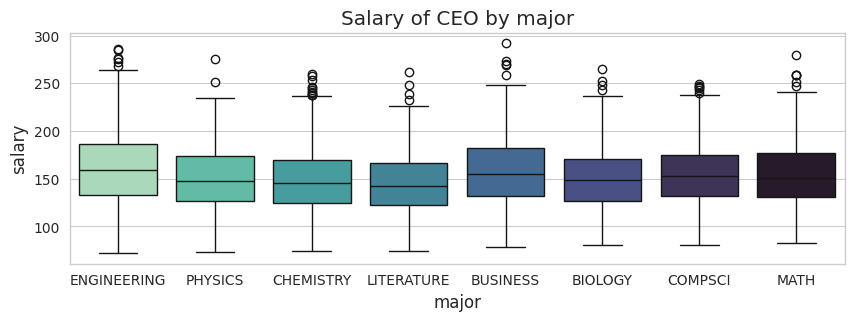

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


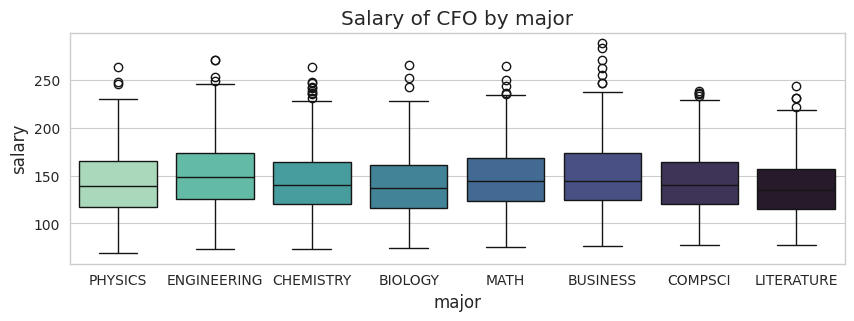

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


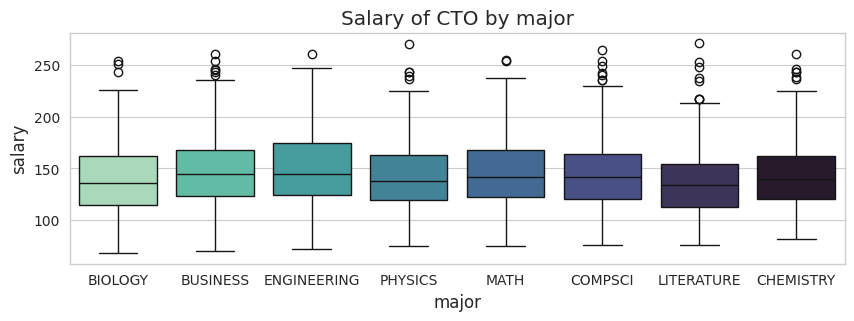

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


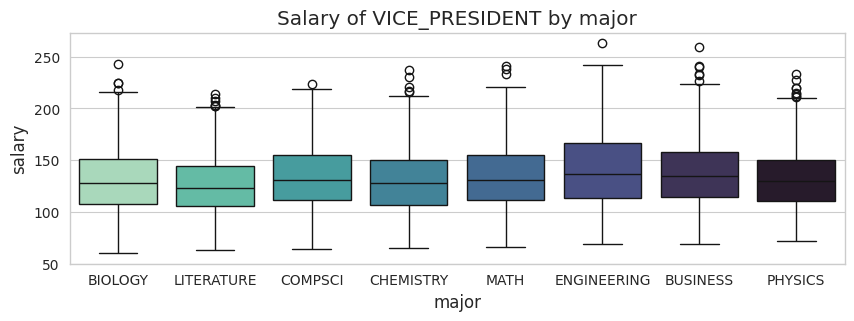

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


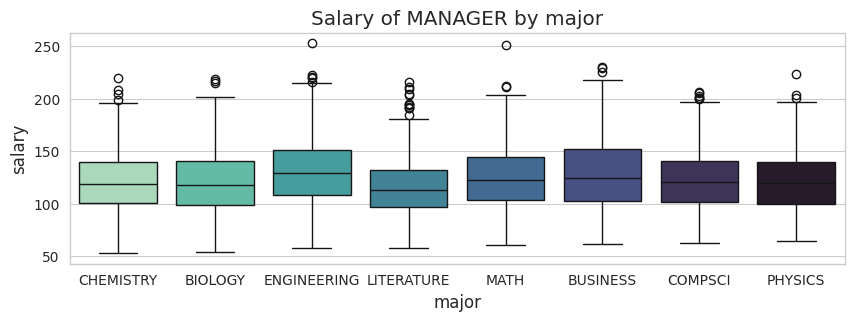

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


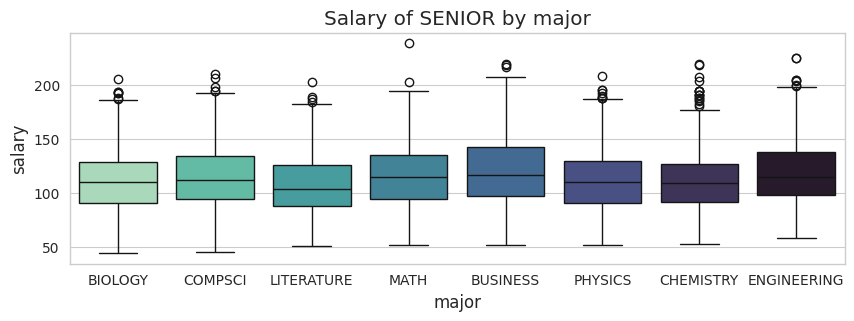

<ipython-input-59-f157ce668142>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')


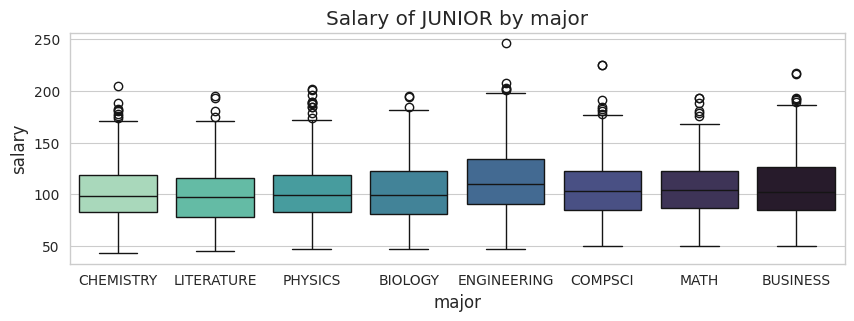

In [59]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

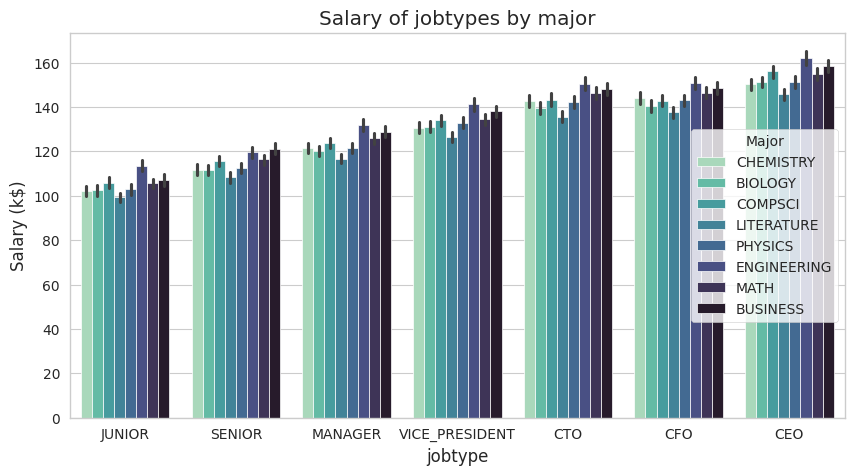

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

In [61]:
df.show(1)

+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [62]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)

False

In [63]:
df_encoded = df_encoded.drop('jobId')

In [64]:
cols = df_encoded.columns

In [65]:
salary_df = df_encoded.select('salary').toPandas()

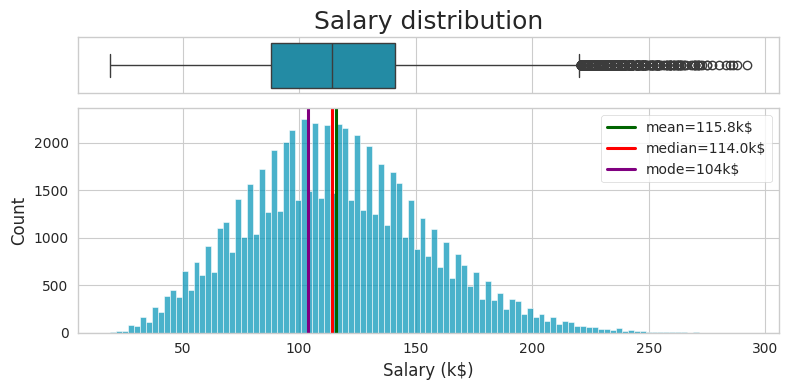

In [67]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [69]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [70]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [71]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [72]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[59,66,71,78,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [73]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 71211 training examples and 344 test examples.


In [74]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [75]:
gbt_model = gbt.fit(train)

In [76]:
predictions = gbt_model.transform(test)

In [77]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.907963904570366

In [78]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7351112302194365

In [79]:
rf_results = predictions.toPandas()

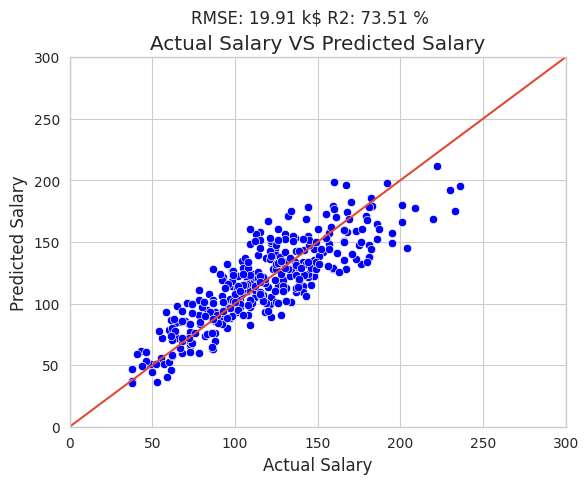

In [80]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [81]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.91 k$ 
R2: 73.51 %


In [82]:
spark.stop()